# <center>Data cleaning project "Flights"

<center> Data was taken from https://codefinity.com/

#### In this small project, I will normalize, clean and prepare the data for further analysis.

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
sample_flights = pd.read_csv('flights_sample.csv', index_col = 0)

print(sample_flights.shape)

print(sample_flights.info())

(116381, 21)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 116381 entries, 2464670 to 4299913
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 116381 non-null  int64  
 1   MONTH                116381 non-null  int64  
 2   DAY                  116381 non-null  int64  
 3   ORIGIN_AIRPORT       116381 non-null  object 
 4   DESTINATION_AIRPORT  116381 non-null  object 
 5   SCHEDULED_DEPARTURE  116381 non-null  int64  
 6   DEPARTURE_TIME       114679 non-null  float64
 7   DEPARTURE_DELAY      114679 non-null  float64
 8   WHEELS_OFF           114623 non-null  float64
 9   SCHEDULED_TIME       116381 non-null  float64
 10  AIR_TIME             114318 non-null  float64
 11  DISTANCE             116381 non-null  int64  
 12  WHEELS_ON            114558 non-null  float64
 13  TAXI_IN              114558 non-null  float64
 14  SCHEDULED_ARRIVAL    116381 non-null  int64  
 1

In [37]:
sample_flights.head()

,YEAR,MONTH,DAY,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,WHEELS_OFF,SCHEDULED_TIME,...,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
2464670,2015,6,5,SFO,BOS,1606,1621.0,15.0,1631.0,346.0,...,2704,40.0,7.0,52,0,NaN,NaN,NaN,NaN,NaN
3928603,2015,9,1,BOS,LGA,1300,1253.0,-7.0,1310.0,83.0,...,184,1406.0,5.0,1423,0,NaN,NaN,NaN,NaN,NaN
3102055,2015,7,13,MCI,BWI,2010,2014.0,4.0,2024.0,150.0,...,967,2326.0,7.0,2340,0,NaN,NaN,NaN,NaN,NaN
5049064,2015,11,12,SMF,LAS,720,721.0,1.0,733.0,85.0,...,397,833.0,7.0,845,0,NaN,NaN,NaN,NaN,NaN
4361783,2015,9,29,MDW,DTW,1335,1344.0,9.0,1406.0,70.0,...,228,1547.0,9.0,1545,0,NaN,NaN,NaN,NaN,NaN


The dataframe has about 116k rows and 21 columns. The first three columns are YEAR, MONTH, and DAY. It's a bit illogical to have 3 separate columns for each date dimension. We should have a separate column with dates.

In [38]:
# Define function
to_date = lambda x: x["MONTH"].astype(str) + "/" + x["DAY"].astype(str) + "/" + x["YEAR"].astype(str)

# Apply function to flights data
sample_flights['date'] = to_date(sample_flights)

sample_flights['date'].tail(5)

3172039    7/17/2015
2127212    5/15/2015
2859979    6/29/2015
3659266    8/15/2015
4299913    9/25/2015
Name: date, dtype: object

In [39]:
# Convert column into date type
sample_flights['date_conv'] = pd.to_datetime(sample_flights["date"], format = "%m/%d/%Y")

# Print minimal and maximal converted dates
print(f"The earliest date in dataset: {min(sample_flights['date_conv'])}")
print(f"The latest date in dataset: {max(sample_flights['date_conv'])}")

# Print number of unqiue dates in dataset
print(f"There are {len(sample_flights['date_conv'].unique())} unique dates in dataset")    

The earliest date in dataset: 2015-01-01 00:00:00
The latest date in dataset: 2015-12-31 00:00:00
There are 365 unique dates in dataset


<AxesSubplot: >

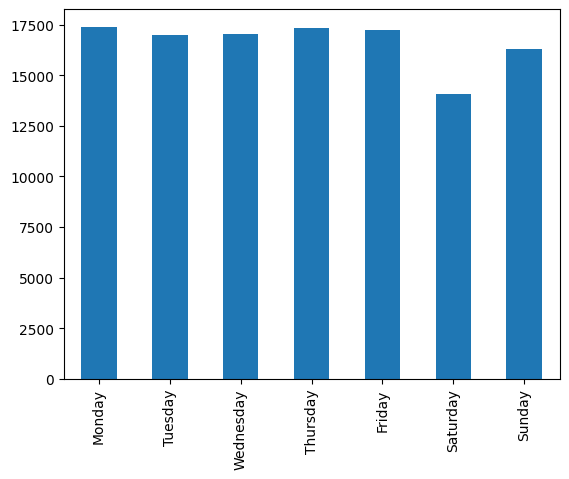

In [40]:
sample_flights['day_of_week'] = sample_flights['date_conv'].dt.day_name()

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sample_flights["day_of_week"].value_counts()[days].plot(kind = 'bar')

Each flight has a 'taxi' phase, which refers to the time before takeoff or after landing. Usually, it refers to the movement of an aircraft on the ground.

In this dataset we have two columns that can help us to evaluate these times: DEPARTURE_TIME - the time a plane finished passenger boarding and started moving on the ground (as float, in the format hhmm.0), and WHEELS_OFF - the time when a plane transitioned from moving along the ground to flying in the air (the same format).

Seems like we can simply subtract the WHEELS_OFF column and DEPARTURE_TIME. But there are some inconveniences. Since both of these columns are float64, it means that if the first digit in the hour is 0, then it won't be displayed. We somehow need to add redundant zeros and place a colon sign as an hour/minute separator.

At first, each time should have the .0 part removed. Then, we consider the main possibilities that can occur there:

In [41]:
# Drop nan values
sample_flights.dropna(subset = ['DEPARTURE_TIME', 'WHEELS_OFF'], inplace = True)

# Implement to_time function
def to_time(x):
    # Remove .0 parts using .replace
    res = str(x).replace('.0', '')
    if len(res) == 1:
        # Concatenate "00:0" and res
        return '00:0' + res
    elif len(res) == 2:
        # Concatenate "00:" and res
        return '00:' + res
    elif len(res) == 3:
        return '0' + res[0] + ":" + res[1:]
    elif res == '2400':
        # Return string "00:00"
        return '00:00'
    else:
        # Add colon sign
        return res[:2] + ':' + res[2:]

# Replacing the columns values   
sample_flights['DEPARTURE_TIME'] = sample_flights['date_conv'].astype(str) + ' ' + sample_flights['DEPARTURE_TIME'].apply(to_time)
sample_flights['WHEELS_OFF'] = sample_flights['date_conv'].astype(str) + " " + sample_flights['WHEELS_OFF'].apply(to_time)

# Print the first 5 observations of DEPARTURE_TIME column
sample_flights['DEPARTURE_TIME'].head(5)

2464670    2015-06-05 16:21
3928603    2015-09-01 12:53
3102055    2015-07-13 20:14
5049064    2015-11-12 07:21
4361783    2015-09-29 13:44
Name: DEPARTURE_TIME, dtype: object

<AxesSubplot: >

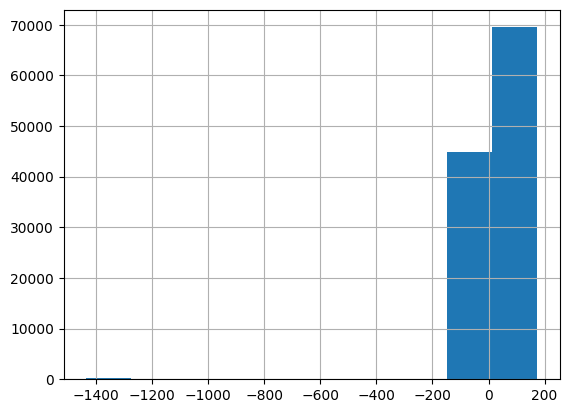

In [42]:
# Convert columns into datetime format
sample_flights['DEPARTURE_TIME'] = pd.to_datetime(sample_flights['DEPARTURE_TIME'], format = '%Y-%m-%d %H:%M')
sample_flights['WHEELS_OFF'] = pd.to_datetime(sample_flights['WHEELS_OFF'], format = '%Y-%m-%d %H:%M')

# Build the histogram for time durations
((sample_flights['WHEELS_OFF'] - sample_flights['DEPARTURE_TIME']).dt.total_seconds()/60).hist()

The last histogram seems a bit biased. Despite the majority of values located in the range close to 0, there were observations located close to -1400.

What is the most interesting part? This is the fact that one day contains 1440 minutes, which most likely means there are date discrepancies for the flights that fly at midnight. As we may recall, we simply concatenated the date we have and the time. But we had no information on what these dates are referred to.

<AxesSubplot: >

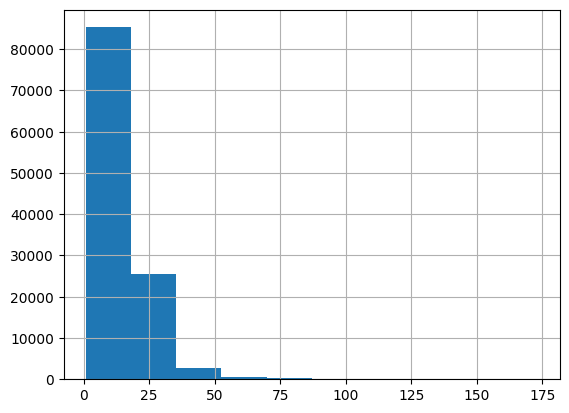

In [43]:
def date_corr(x):
    # Compare the number of seconds with 0
    if (x["WHEELS_OFF"] - x["DEPARTURE_TIME"]).total_seconds() < 0:
        return x['WHEELS_OFF'] + pd.Timedelta(days=1)
    else:
        return x['WHEELS_OFF']

sample_flights['WHEELS_OFF'] = sample_flights.apply(lambda x: date_corr(x), axis = 1)

# Build the histogram for time durations
((sample_flights['WHEELS_OFF'] - sample_flights['DEPARTURE_TIME']).dt.total_seconds()/60).hist()

As we can see, the majority of flights spent less than 25 minutes after passenger boarding, but before takeoff. There were values greater than 100, but these are possible in real life.

In [44]:
# Calculate the arrival time
sample_flights['ARRIVAL_TIME'] = sample_flights['WHEELS_OFF'] + pd.to_timedelta(sample_flights['AIR_TIME'], unit = 'minutes') + pd.to_timedelta(sample_flights['TAXI_IN'], unit = 'minutes')
        
print(sample_flights['ARRIVAL_TIME'].tail(5))

3397638   2015-07-31 12:35:00
3172039   2015-07-17 22:57:00
2127212   2015-05-15 19:12:00
2859979   2015-06-29 11:12:00
4299913   2015-09-25 14:44:00
Name: ARRIVAL_TIME, dtype: datetime64[ns]


Now we can calculate the delays for each flight by subtracting the actual arriving time from the scheduled one.

<AxesSubplot: >

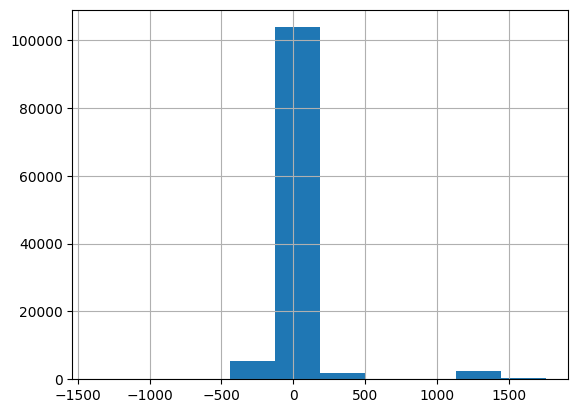

In [45]:
flights = pd.read_csv('flights.csv', parse_dates = ['date_conv', 'WHEELS_OFF', 'DEPARTURE_TIME', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME'], index_col = 0)

# Create column for arrival delays
flights['ARRIVAL_DELAY'] = flights['ARRIVAL_TIME'] - flights['SCHEDULED_ARRIVAL']

(flights['ARRIVAL_DELAY'].dt.total_seconds()/60).hist()

Well, we can see that there are values on both sides close to 1400. Remember, that there are 1440 minutes in 1 day, which means that these outliers most likely occurred due to midnight flights.



<AxesSubplot: >

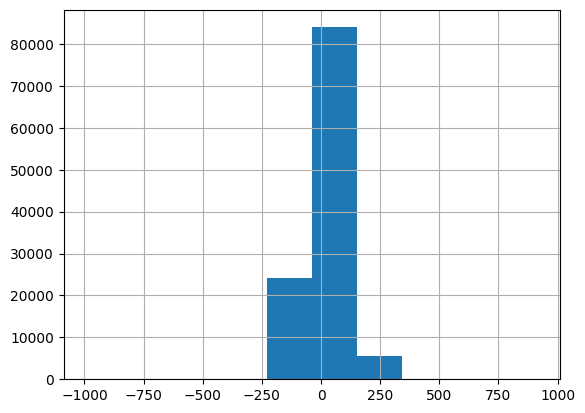

In [46]:
# Define function
def date_corr(x):
    if (x["ARRIVAL_TIME"] - x["SCHEDULED_ARRIVAL"]).total_seconds()/60 > 1000:
        return x['ARRIVAL_TIME'] - pd.Timedelta('1 day')
    elif (x["ARRIVAL_TIME"] - x["SCHEDULED_ARRIVAL"]).total_seconds()/60 < -1000:
        return x['ARRIVAL_TIME'] + pd.Timedelta('1 day')
    else:
        return x['ARRIVAL_TIME']

# Apply function to column
flights['ARRIVAL_TIME'] = flights.apply(lambda x: date_corr(x), axis = 1)

((flights['ARRIVAL_TIME'] - flights['SCHEDULED_ARRIVAL']).dt.total_seconds()/60).hist()

Despite having arrival times corrected (as we thought), the distribution of delays remains quite wide (up to 1000 minutes on both boundaries).

Let's find out if there is a relationship between flight distance and delay.

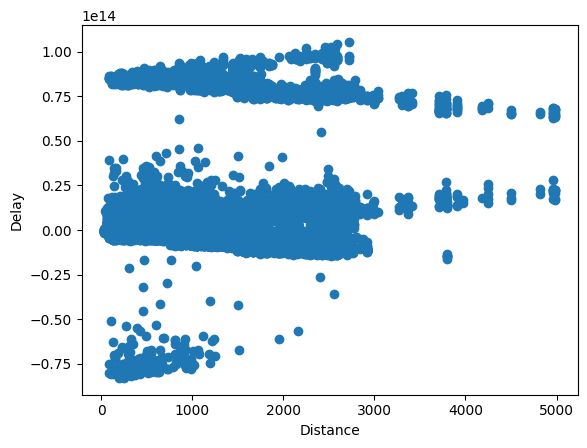

In [47]:
fig, ax = plt.subplots()

ax.scatter(x = flights['DISTANCE'], y = flights['ARRIVAL_DELAY'])

ax.set(xlabel = 'Distance', ylabel = 'Delay')

plt.show()

The last scatter plot contains interesting patterns, like the right part (a distance greater than 3000) that looks like two symmetric lines. Or the bottom one - also like two symmetric lines. The reason we could miss - is the time zones shift, since the scheduled arrival times are represented as local.

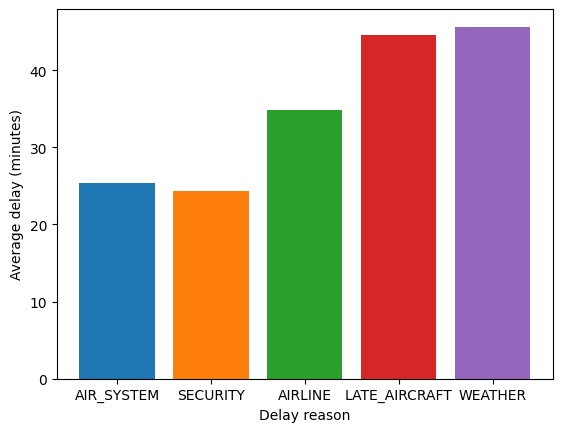

In [48]:
fig, ax = plt.subplots()

# Filter to only delays columns
delays = flights[['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']]

for i in delays.columns:
    ind = (flights[i].isna() == False) & (flights[i] != 0)
    y = flights.loc[ind][i].sum()/len(flights.loc[ind][i])
    ax.bar(x = i.replace('_DELAY', ""), height = y)

ax.set(xlabel = 'Delay reason', ylabel = 'Average delay (minutes)')
plt.show()

As we can see, most of the delays are related to weather conditions.